In [ ]:
# Used Bike Prices – Feature Engineering & EDA
# Author: Bhuvneshwar
# Description: Predicting used bike prices using feature engineering, EDA, and ML models.

# ======================
# 1. IMPORT LIBRARIES
# ======================
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install scikit-learn

In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv('bikes.csv')
print("Dataset shape:", df.shape)
df.head()


In [ ]:
import numpy as np

# Remove duplicates and reset index
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

# Handle missing values in location
df['location'].fillna("Unknown", inplace=True)

# Clean numeric columns (kms_driven, mileage, power)
for col in ['kms_driven', 'mileage', 'power']:
    df[col] = df[col].astype(str).str.extract(r'(\d+\.?\d*)')[0].astype(float)

# Extract engine_cc from model_name
df['engine_cc'] = df['model_name'].str.extract(r'(\d+)\s*cc')[0].astype(float)
df['engine_cc'].fillna(df['engine_cc'].median(), inplace=True)

# Extract brand from model_name
df['brand'] = df['model_name'].str.split().str[0]

df.head()


In [ ]:
import datetime

current_year = datetime.datetime.now().year

# Bike age
df['bike_age'] = current_year - df['model_year']

# Power-to-cc ratio
df['power_to_cc'] = df['power'] / df['engine_cc']

# Log-transform price
df['price_log'] = np.log1p(df['price'])

df[['engine_cc','power','mileage','bike_age','power_to_cc','price','price_log']].head()


In [ ]:
# Features and target
X = df[['engine_cc','power','mileage','bike_age','power_to_cc','location','brand']]
y = df['price_log']

# Fill remaining missing values
num_features = ['engine_cc','power','mileage','bike_age','power_to_cc']
cat_features = ['location','brand']

X[num_features] = X[num_features].fillna(X[num_features].median())
X[cat_features] = X[cat_features].fillna('Unknown')

X.head()


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

results = {}

for name, model in models.items():
    pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}
    print(f"{name} -> MAE: {mae:.3f}, RMSE: {rmse:.3f}, R2: {r2:.3f}")

# Summary
results_df = pd.DataFrame(results).T
print("\nModel Performance Summary:")
print(results_df)


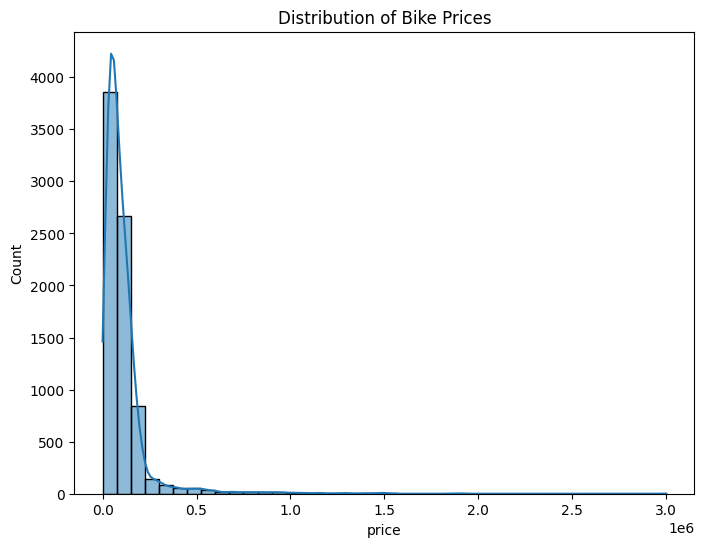

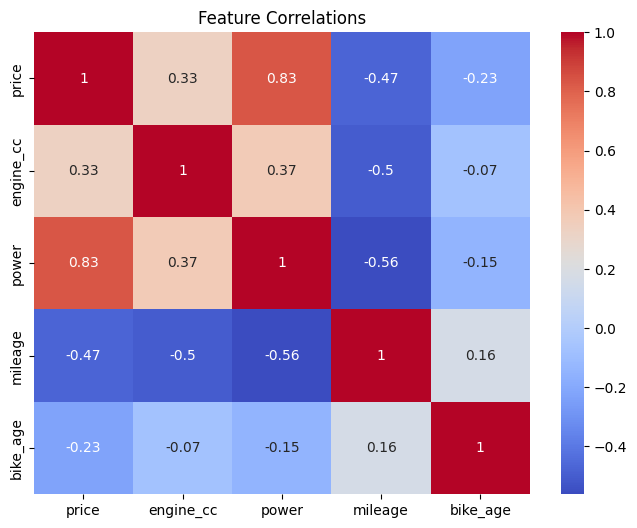

In [ ]:
# EXPLORATORY DATA ANALYSIS
plt.figure(figsize=(8,6))
sns.histplot(df['price'], bins=40, kde=True)
plt.title("Distribution of Bike Prices")
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(df[['price','engine_cc','power','mileage','bike_age']].corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlations")
plt.show()


In [ ]:
# HYPERPARAMETER TUNING (Example: Random Forest)
rf_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                              ("model", RandomForestRegressor(random_state=42))])

param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [10, 20, None]
}

grid = GridSearchCV(rf_pipeline, param_grid, cv=3, scoring="r2", n_jobs=-1)
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
print("Best CV R2:", grid.best_score_)


Best Params: {'model__max_depth': 10, 'model__n_estimators': 200}
Best CV R2: 0.5167745198273241


In [ ]:
# 9. FINAL EVALUATION
best_model = grid.best_estimator_
y_pred_final = best_model.predict(X_test)

print("Final Test Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_final))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_final)))
print("R2:", r2_score(y_test, y_pred_final))


Final Test Performance:
MAE: 0.24605915280436816
RMSE: 0.8411870633398767
R2: 0.4954780681857548


               Model       MAE      RMSE        R2
0  Linear Regression  0.303860  0.849255  0.485753
1      Random Forest  0.239711  0.846569  0.489001
2  Gradient Boosting  0.250429  0.818104  0.522788


C:\Users\Bhuvneshwar\AppData\Local\Temp\ipykernel_30132\1046744618.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="R2", data=results_df, palette="viridis")


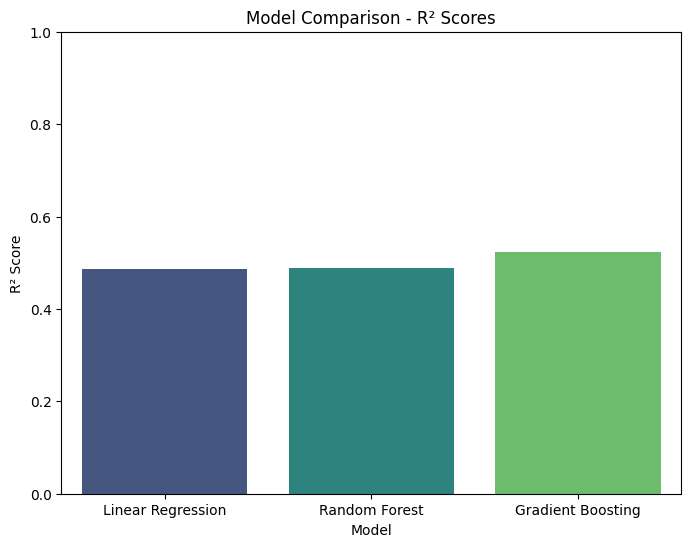

C:\Users\Bhuvneshwar\AppData\Local\Temp\ipykernel_30132\1046744618.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="MAE", data=results_df, palette="magma", ax=axes[0])
C:\Users\Bhuvneshwar\AppData\Local\Temp\ipykernel_30132\1046744618.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="RMSE", data=results_df, palette="cividis", ax=axes[1])


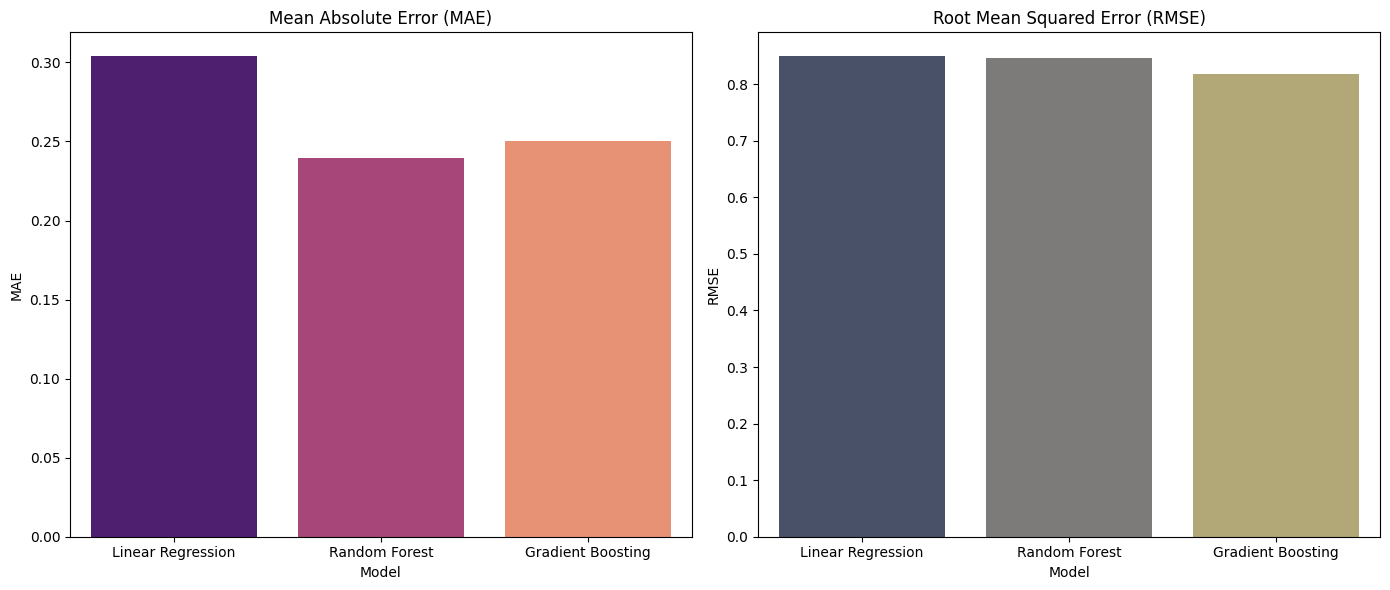

In [ ]:
# 10. MODEL COMPARISON VISUALIZATION

# Convert results dict into DataFrame
results_df = pd.DataFrame(results).T  # transpose for models as rows
results_df = results_df.reset_index().rename(columns={"index":"Model"})

print(results_df)

# Plot R² scores
plt.figure(figsize=(8,6))
sns.barplot(x="Model", y="R2", data=results_df, palette="viridis")
plt.title("Model Comparison - R² Scores")
plt.ylabel("R² Score")
plt.ylim(0,1)
plt.show()

# Plot MAE/RMSE for comparison
fig, axes = plt.subplots(1, 2, figsize=(14,6))

sns.barplot(x="Model", y="MAE", data=results_df, palette="magma", ax=axes[0])
axes[0].set_title("Mean Absolute Error (MAE)")
axes[0].set_ylabel("MAE")

sns.barplot(x="Model", y="RMSE", data=results_df, palette="cividis", ax=axes[1])
axes[1].set_title("Root Mean Squared Error (RMSE)")
axes[1].set_ylabel("RMSE")

plt.tight_layout()
plt.show()
